In [9]:
# Referenced paper: Neural Graph Collaborative Filtering 
# https://arxiv.org/abs/1905.08108

In [10]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn.functional as F
import scipy.sparse as sp

from torch import nn

In [2]:
import pandas as pd
import torch

import os
from time import time
from datetime import datetime

from utils.load_data import Data
from utils.helper_functions import early_stopping,\
                                   train,\
                                   split_matrix,\
                                   compute_ndcg_k,\
                                   eval_model

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.cuda.set_device(0)

In [4]:
class NGCF(nn.Module):
    def __init__(self, n_users, n_items, emb_dim, layers, reg, node_dropout, mess_dropout,
        adj_mtx):
        super().__init__()

        # initialize Class attributes
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.adj_mtx = adj_mtx
        self.laplacian = adj_mtx - sp.eye(adj_mtx.shape[0])
        self.reg = reg
        self.layers = layers
        self.n_layers = len(self.layers)
        self.node_dropout = node_dropout
        self.mess_dropout = mess_dropout

        #self.u_g_embeddings = nn.Parameter(torch.empty(n_users, emb_dim+np.sum(self.layers)))
        #self.i_g_embeddings = nn.Parameter(torch.empty(n_items, emb_dim+np.sum(self.layers)))

        # Initialize weights
        self.weight_dict = self._init_weights()
        print("Weights initialized.")

        # Create Matrix 'A', PyTorch sparse tensor of SP adjacency_mtx
        self.A = self._convert_sp_mat_to_sp_tensor(self.adj_mtx)
        self.L = self._convert_sp_mat_to_sp_tensor(self.laplacian)

    # initialize weights
    def _init_weights(self):
        print("Initializing weights...")
        weight_dict = nn.ParameterDict()

        initializer = torch.nn.init.xavier_uniform_
        
        weight_dict['user_embedding'] = nn.Parameter(initializer(torch.empty(self.n_users, self.emb_dim).to(device)))
        weight_dict['item_embedding'] = nn.Parameter(initializer(torch.empty(self.n_items, self.emb_dim).to(device)))

        weight_size_list = [self.emb_dim] + self.layers
      
        for k in range(self.n_layers):
            weight_dict['W_gc_%d' %k] = nn.Parameter(initializer(torch.empty(weight_size_list[k], weight_size_list[k+1]).to(device)))
            weight_dict['b_gc_%d' %k] = nn.Parameter(initializer(torch.empty(1, weight_size_list[k+1]).to(device)))
            
            weight_dict['W_bi_%d' %k] = nn.Parameter(initializer(torch.empty(weight_size_list[k], weight_size_list[k+1]).to(device)))
            weight_dict['b_bi_%d' %k] = nn.Parameter(initializer(torch.empty(1, weight_size_list[k+1]).to(device)))
           
        return weight_dict

    # convert sparse matrix into sparse PyTorch tensor
    def _convert_sp_mat_to_sp_tensor(self, X):
        """
        Convert scipy sparse matrix to PyTorch sparse matrix

        Arguments:
        ----------
        X = Adjacency matrix, scipy sparse matrix
        """
        coo = X.tocoo().astype(np.float32)
        i = torch.LongTensor(np.mat([coo.row, coo.col]))
        v = torch.FloatTensor(coo.data)
        res = torch.sparse.FloatTensor(i, v, coo.shape).to(device)
        return res

    # apply node_dropout
    def _droupout_sparse(self, X):
        """
        Drop individual locations in X
        
        Arguments:
        ---------
        X = adjacency matrix (PyTorch sparse tensor)
        dropout = fraction of nodes to drop
        noise_shape = number of non non-zero entries of X
        """
        
        node_dropout_mask = ((self.node_dropout) + torch.rand(X._nnz())).floor().bool().to(device)
        i = X.coalesce().indices()
        v = X.coalesce()._values()
        i[:,node_dropout_mask] = 0
        v[node_dropout_mask] = 0
        X_dropout = torch.sparse.FloatTensor(i, v, X.shape).to(X.device)

        return  X_dropout.mul(1/(1-self.node_dropout))

    def forward(self, u, i, j):
        """
        Computes the forward pass
        
        Arguments:
        ---------
        u = user
        i = positive item (user interacted with item)
        j = negative item (user did not interact with item)
        """
        # apply drop-out mask
        A_hat = self._droupout_sparse(self.A) if self.node_dropout > 0 else self.A
        L_hat = self._droupout_sparse(self.L) if self.node_dropout > 0 else self.L

        ego_embeddings = torch.cat([self.weight_dict['user_embedding'], self.weight_dict['item_embedding']], 0)

        all_embeddings = [ego_embeddings]

        # forward pass for 'n' propagation layers
        for k in range(self.n_layers):

            # weighted sum messages of neighbours
            side_embeddings = torch.sparse.mm(A_hat, ego_embeddings)
            side_L_embeddings = torch.sparse.mm(L_hat, ego_embeddings)

            # transformed sum weighted sum messages of neighbours
            sum_embeddings = torch.matmul(side_embeddings, self.weight_dict['W_gc_%d' % k]) + self.weight_dict['b_gc_%d' % k]

            # bi messages of neighbours
            bi_embeddings = torch.mul(ego_embeddings, side_L_embeddings)
            # transformed bi messages of neighbours
            bi_embeddings = torch.matmul(bi_embeddings, self.weight_dict['W_bi_%d' % k]) + self.weight_dict['b_bi_%d' % k]

            # non-linear activation 
            ego_embeddings = F.leaky_relu(sum_embeddings + bi_embeddings)
            # + message dropout
            mess_dropout_mask = nn.Dropout(self.mess_dropout)
            ego_embeddings = mess_dropout_mask(ego_embeddings)

            # normalize activation
            norm_embeddings = F.normalize(ego_embeddings, p=2, dim=1)

            all_embeddings.append(norm_embeddings)

        all_embeddings = torch.cat(all_embeddings, 1)
        
        # back to user/item dimension
        u_g_embeddings, i_g_embeddings = all_embeddings.split([self.n_users, self.n_items], 0)

        self.u_g_embeddings = nn.Parameter(u_g_embeddings)
        self.i_g_embeddings = nn.Parameter(i_g_embeddings)
        
        u_emb = u_g_embeddings[u] # user embeddings
        p_emb = i_g_embeddings[i] # positive item embeddings
        n_emb = i_g_embeddings[j] # negative item embeddings

        y_ui = torch.mul(u_emb, p_emb).sum(dim=1)
        y_uj = torch.mul(u_emb, n_emb).sum(dim=1)
        log_prob = (torch.log(torch.sigmoid(y_ui-y_uj))).mean()

        # compute bpr-loss
        bpr_loss = -log_prob
        if self.reg > 0.:
            l2norm = (torch.sum(u_emb**2)/2. + torch.sum(p_emb**2)/2. + torch.sum(n_emb**2)/2.) / u_emb.shape[0]
            l2reg  = self.reg*l2norm
            bpr_loss =  -log_prob + l2reg

        return bpr_loss


In [5]:
batch_size=1024
data_dir='./data/'
dataset='ml-100k'
emb_dim=64
eval_N=1
k=20
layers=[64]
lr=0.0001
mess_dropout=0.1
n_epochs=400
node_dropout=0.0
reg=1e-05
esults_dir='results'
save_results=1

# generate the NGCF-adjacency matrix
data_generator = Data(path=data_dir + dataset, batch_size=batch_size)
adj_mtx = data_generator.get_adj_mat()

n_users=943, n_items=1682
n_interactions=100000
n_train=80064, n_test=19936, sparsity=0.06305
Creating interaction matrices R_train and R_test...
Complete. Interaction matrices R_train and R_test created in 0.8148708343505859 sec
Loaded adjacency-matrix (shape: (2625, 2625) ) in 0.00932002067565918 sec.


In [6]:
# create model name and save
modelname =  "NGCF" + \
        "_bs_" + str(batch_size) + \
        "_nemb_" + str(emb_dim) + \
        "_layers_" + str(layers) + \
        "_nodedr_" + str(node_dropout) + \
        "_messdr_" + str(mess_dropout) + \
        "_reg_" + str(reg) + \
        "_lr_"  + str(lr)

# create NGCF model
model = NGCF(data_generator.n_users, 
                 data_generator.n_items,
                 emb_dim,
                 layers,
                 reg,
                 node_dropout,
                 mess_dropout,
                 adj_mtx)

Initializing weights...


/home/yichen/miniconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Weights initialized.


In [7]:
if use_cuda:
    model = model.cuda()

Start at 2021-04-10 21:40:29.014338
Using cuda for computations
Params on CUDA: True
Epoch: 0, Training time: 2.64s, Loss: 54.7800
Evaluate current model:
 Epoch: 0, Validation time: 0.69s 
 Loss: 54.7800: 
 Recall@20: 0.0103 
 NDCG@20: 0.0743
Epoch: 1, Training time: 2.64s, Loss: 54.6990
Evaluate current model:
 Epoch: 1, Validation time: 0.65s 
 Loss: 54.6990: 
 Recall@20: 0.0112 
 NDCG@20: 0.0778
Epoch: 2, Training time: 2.59s, Loss: 54.6064
Evaluate current model:
 Epoch: 2, Validation time: 0.66s 
 Loss: 54.6064: 
 Recall@20: 0.0109 
 NDCG@20: 0.0759
Epoch: 3, Training time: 2.69s, Loss: 54.5517
Evaluate current model:
 Epoch: 3, Validation time: 0.68s 
 Loss: 54.5517: 
 Recall@20: 0.0140 
 NDCG@20: 0.0892
Epoch: 4, Training time: 2.61s, Loss: 54.4445
Evaluate current model:
 Epoch: 4, Validation time: 0.65s 
 Loss: 54.4445: 
 Recall@20: 0.0141 
 NDCG@20: 0.0881
Epoch: 5, Training time: 2.61s, Loss: 54.3108
Evaluate current model:
 Epoch: 5, Validation time: 0.62s 
 Loss: 54.3108:

Epoch: 51, Training time: 2.59s, Loss: 24.7827
Evaluate current model:
 Epoch: 51, Validation time: 0.60s 
 Loss: 24.7827: 
 Recall@20: 0.2691 
 NDCG@20: 0.5908
Epoch: 52, Training time: 2.58s, Loss: 24.4161
Evaluate current model:
 Epoch: 52, Validation time: 0.60s 
 Loss: 24.4161: 
 Recall@20: 0.2691 
 NDCG@20: 0.5915
Epoch: 53, Training time: 2.58s, Loss: 23.9449
Evaluate current model:
 Epoch: 53, Validation time: 0.60s 
 Loss: 23.9449: 
 Recall@20: 0.2702 
 NDCG@20: 0.5884
Epoch: 54, Training time: 2.59s, Loss: 23.6352
Evaluate current model:
 Epoch: 54, Validation time: 0.60s 
 Loss: 23.6352: 
 Recall@20: 0.2713 
 NDCG@20: 0.5954
Epoch: 55, Training time: 2.58s, Loss: 23.3452
Evaluate current model:
 Epoch: 55, Validation time: 0.60s 
 Loss: 23.3452: 
 Recall@20: 0.2683 
 NDCG@20: 0.5957
Epoch: 56, Training time: 2.59s, Loss: 23.0918
Evaluate current model:
 Epoch: 56, Validation time: 0.60s 
 Loss: 23.0918: 
 Recall@20: 0.2723 
 NDCG@20: 0.5987
Epoch: 57, Training time: 2.59s, L

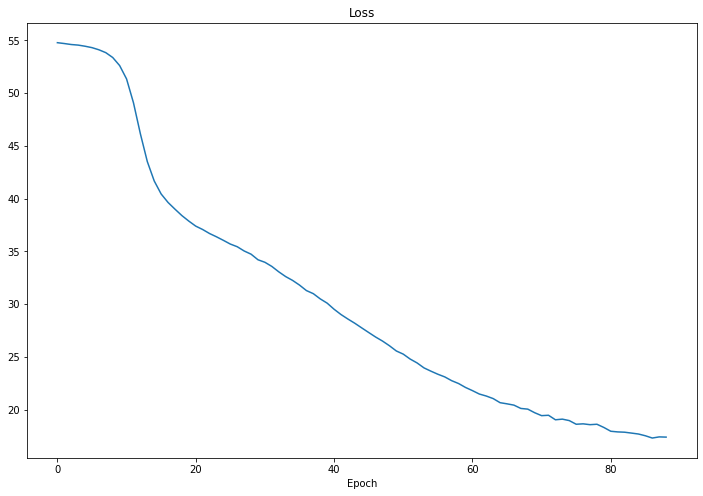

In [8]:
# current best metric
cur_best_metric = 0

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Set values for early stopping
cur_best_loss, stopping_step, should_stop = 1e3, 0, False
today = datetime.now()

print("Start at " + str(today))
print("Using " + str(device) + " for computations")
print("Params on CUDA: " + str(next(model.parameters()).is_cuda))

results = {"Epoch": [],
               "Loss": [],
               "Recall": [],
               "NDCG": [],
               "Training Time": []}


for epoch in range(n_epochs):
    t1 = time()
    loss = train(model, data_generator, optimizer)
    training_time = time()-t1
    print("Epoch: {}, Training time: {:.2f}s, Loss: {:.4f}".
            format(epoch, training_time, loss))
    
    # print test evaluation metrics every N epochs (provided by eval_N)
    if epoch % eval_N  == (eval_N - 1):
        with torch.no_grad():
            t2 = time()
            recall, ndcg = eval_model(model.u_g_embeddings.detach(),
                                          model.i_g_embeddings.detach(),
                                          data_generator.R_train,
                                          data_generator.R_test,
                                          k)
        print(
                "Evaluate current model:\n",
                "Epoch: {}, Validation time: {:.2f}s".format(epoch, time()-t2),"\n",
                "Loss: {:.4f}:".format(loss), "\n",
                "Recall@{}: {:.4f}".format(k, recall), "\n",
                "NDCG@{}: {:.4f}".format(k, ndcg)
                )
        cur_best_metric, stopping_step, should_stop = \
        early_stopping(recall, cur_best_metric, stopping_step, flag_step=5)
        
        # save results in dict
        results['Epoch'].append(epoch)
        results['Loss'].append(loss)
        results['Recall'].append(recall.item())
        results['NDCG'].append(ndcg.item())
        results['Training Time'].append(training_time)
    else:
        # save results in dict
        results['Epoch'].append(epoch)
        results['Loss'].append(loss)
        results['Recall'].append(None)
        results['NDCG'].append(None)
        results['Training Time'].append(training_time)
    if should_stop == True: break

        
# save
if save_results:
    date = today.strftime("%d%m%Y_%H%M") 
    
    # save model as .pt file
    if os.path.isdir("./models"):
        torch.save(model.state_dict(), "./models/" + str(date) + "_" + modelname + "_" + dataset + ".pt")
    else:
        os.mkdir("./models")
        torch.save(model.state_dict(), "./models/" + str(date) + "_" + modelname + "_" + dataset + ".pt")

    # save results as pandas dataframe
    results_df = pd.DataFrame(results)
    results_df.set_index('Epoch', inplace=True)
    if os.path.isdir("./results"):
        results_df.to_csv("./results/" + str(date) + "_" + modelname + "_" + dataset + ".csv")
    else:
        os.mkdir("./results")
        results_df.to_csv("./results/" + str(date) + "_" + modelname + "_" + dataset + ".csv")
    # plot loss
    results_df['Loss'].plot(figsize=(12,8), title='Loss')